<a href="https://colab.research.google.com/github/anirbanl/jax-code/blob/master/rlflax/jax_flax_reinforcev2_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jax jaxlib flax

     |████████████████████████████████| 184kB 7.9MB/s 
     |████████████████████████████████| 122kB 14.5MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 


In [2]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import jax
import jax.numpy as jp
from jax.ops import index, index_add, index_update
from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd, value_and_grad
from functools import partial
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax.core import freeze, unfreeze
import optax                           # Optimizers
from typing import Sequence

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print(env.action_space.n)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
2


In [4]:
h_size = 16
a_size = 2
s_size = 4

In [5]:
class REINFORCE(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(self.features[0])(x))
        x = nn.softmax(nn.Dense(self.features[1])(x))
        return x

key1, key2 = random.split(random.PRNGKey(1000), 2)
x = random.uniform(key1, (s_size, ))

model = REINFORCE(features=[h_size, a_size])
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameter shapes:\n', jax.tree_map(jp.shape, unfreeze(params)))
print('output:\n', y)

initialized parameter shapes:
 {'params': {'Dense_0': {'bias': (16,), 'kernel': (4, 16)}, 'Dense_1': {'bias': (2,), 'kernel': (16, 2)}}}
output:
 [0.28162536 0.71837467]


In [6]:
def create_train_state(rng, learning_rate, s_size, h_size, a_size):
  """Creates initial `TrainState`."""
  model = REINFORCE(features=[h_size, a_size])
  params = model.init(rng, jp.ones((s_size, )))#['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

In [7]:
def one_hot(x, k, dtype=jp.float32):
    """Create a one-hot encoding of x of size k."""
    return jp.array(x[:, None] == jp.arange(k), dtype)

def cumulative_returns(rewards, gamma):
    returns = jp.zeros(len(rewards))
    next_return = 0 # 0 because we start at the last timestep
    for t in reversed(range(0, len(rewards))):
        next_return = rewards[t] + gamma * next_return
        returns = index_update(returns, index[t], next_return)
    # normalize for better statistical properties
    returns = (returns - returns.mean()) / (returns.std() + jp.finfo(jp.float32).eps)
    return returns

@jit
def train_step(ts, sar, gamma=1.0):
    """Train for a single step."""
    sar['r'] = cumulative_returns(sar['r'], gamma)
    sar['s'] = jp.array(sar['s'])
    sar['a'] = jp.array(sar['a'])
    # print(f"return shape:{sar['r'].shape}\n")
    # print(f"state shape:{sar['s'].shape}\n")
    # print(f"action shape:{sar['a'].shape}\n")

    def loss_fn(params):
        one_hot_actions = one_hot(sar['a'], a_size)
        probs = ts.apply_fn(params, sar['s'])
        # print(f"oh actions shape:{one_hot_actions.shape}, probs shape:{probs.shape}, return shape:{sar['r'].shape}\n")
        return jp.einsum('ij,i->',- one_hot_actions * jp.log(probs), sar['r'])

    loss, grads = jax.value_and_grad(loss_fn)(ts.params)
    return ts.apply_gradients(grads=grads), loss

def act(key, ts, state):
    probs = ts.apply_fn(ts.params, state)
    key, _ = jax.random.split(key)
    uf = jax.random.uniform(key, (1,), minval=0.0, maxval=1.0)[0]
    action = jp.argmax(uf < jp.cumsum(probs))
    return key, action.item()


In [8]:
def reinforce(key, env, ts, n_episodes=10000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        # print(f"Episode {i_episode}")
        saved_log_probs = []
        rewards = []
        sar = {key: [] for key in 'sar'}
        state = env.reset()
        # print(f'State:{state}')
        for t in range(max_t):
            key, action = act(key, ts, state)
            # print(f'Action:{action}')
            sar['s'].append(state)
            sar['a'].append(action)
            state, reward, done, _ = env.step(action)
            sar['r'].append(reward)
            rewards.append(reward)
            if done:
                # print(f'Done {t}')
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        ts, l = train_step(ts, sar, gamma)
        # print(f'loss {l}')
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: 2
Episode 100	Average Score: 44.70
Episode 200	Average Score: 165.79
Episode 300	Average Score: 190.24
Environment solved in 244 episodes!	Average Score: 195.37


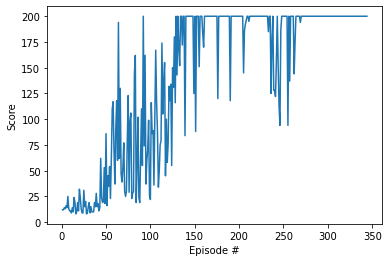

In [11]:
def main():
    env = gym.make('CartPole-v0')
    env.seed(0)
    print('observation space:', env.observation_space)
    print('action space:', env.action_space.n)
    rng = jax.random.PRNGKey(0)
    ts = create_train_state(rng, 1e-2, s_size, h_size, a_size)
    scores = reinforce(rng, env, ts)
    plot_scores(scores)

if __name__ == '__main__':
    main()